In [ ]:
#default_exp audio.augment
#default_cls_lvl 3

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Data Augmentation for Audio

> Transforms to apply data augmentation to AudioSpectrograms and Signals

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.vision.core import *
from local.vision.augment import *
from local.notebook.showdoc import show_doc
from local.audio.core import *
from local.learner import *
from local.vision.models.xresnet import *
from local.metrics import *

In [ ]:
# export
import torch.nn
from torch import stack, zeros_like as t0, ones_like as t1
from torch.distributions.bernoulli import Bernoulli
from librosa.effects import split
from dataclasses import asdict
from scipy.signal import resample_poly
from scipy.ndimage.interpolation import shift
import librosa
import colorednoise as cn

# Table of Contents
1. [Preprocessing Functions](#Preprocessing-Functions)  
    1. [Remove Silence](#Remove-Silence)
    1. [Resampling](#Resampling)
1. [Signal Transforms](#Signal-Transforms)
    1. [Signal Cropping/Padding](#Signal-Cropping/Padding)
    1. [Signal Shifting](#Signal-Shifting)
    1. [Add Noise to Signal](#Add-Noise-to-Signal)
    1. [Adjust Volume](#Adjust-Volume)
    1. [Signal Cutout](#Signal-Cutout)
    1. [Signal Loss](#Signal-Loss)
    1. [DownmixMono](#DownmixMono)
1. [Spectrogram Transforms](#Spectrogram-Transforms)
    1. [Time Cropping](#Time-Cropping)
    1. [Time and Frequency Masking (SpecAugment)](#Time-and-Frequency-Masking-(SpecAugment))
    1. [Spectrogram Rolling](#Spectrogram-Rolling)
    1. [Delta/Accelerate](#Delta/Accelerate)
1. [Pipelines](#Pipelines)
    1. [Signal Pipelines](#Signal-Pipelines)
    1. [Spectrogram Pipelines](#Spectrogram-Pipelines)

In [ ]:
##export
#_all_ = ['AudioGetter', 'get_audio_files', 'AudioItem', 'OpenAudio', 'AudioSpectrogram', 'AudioToSpec',
 #       'SpectrogramConfig', 'AudioConfig', 'audio_extensions']

## Setup Examples

In [ ]:
p = Config()['data_path'] / 'ST-AEDS-20180100_1-OS'
x = AudioGetter("", recurse=True, folders=None)
files = x(p)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
#files will load differently on different machines so we specify examples by name
ex_files = [p/f for f in ['m0005_us_m0005_00218.wav', 
                                'f0003_us_f0003_00279.wav', 
                                'f0001_us_f0001_00168.wav', 
                                'f0005_us_f0005_00286.wav',]]

In [ ]:
audio_orig = AudioItem.create(ex_files[0])
a2s = AudioToSpec(n_fft = 1024, hop_length=256)
sg_orig = a2s(audio_orig)

In [ ]:
#get 3 equal length portions of 3 different signals so we can stack them
#for a fake multichannel example
ai0, ai1, ai2 = map(AudioItem.create, ex_files[1:4]);
min_samples = min(ai0.nsamples, ai1.nsamples, ai2.nsamples)
s0, s1, s2 = map(lambda x: x[:,:min_samples], (ai0.sig, ai1.sig, ai2.sig))
fake_multichannel = AudioItem((torch.stack((s0, s1, s2), dim=1).squeeze(0), 16000, None))
sg_multi = a2s(fake_multichannel)

# Preprocessing Functions

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong><br/>
    1. Add in longer clips (whale) and do more extensive testing. Current clip only allows us to test Trim, not All or Split<br/></div>


##  Remove Silence

In [ ]:
#export
mk_class('RemoveType', **{o:o.lower() for o in ['Trim', 'All', 'Split']},
         doc="All methods of removing silence as attributes to get tab-completion and typo-proofing")

In [ ]:
#export
def _merge_splits(splits, pad):
    clip_end = splits[-1][1]
    merged = []
    i=0
    while i < len(splits):
        start = splits[i][0]
        while splits[i][1] < clip_end and splits[i][1] + pad >= splits[i+1][0] - pad:
            i += 1
        end = splits[i][1]
        merged.append(np.array([max(start-pad, 0), min(end+pad, clip_end)]))
        i+=1
    return np.stack(merged)

def RemoveSilence(remove_type=RemoveType.Trim, threshold=20, pad_ms=20):
    def _inner(ai:AudioItem)->AudioItem:
        '''Split signal at points of silence greater than 2*pad_ms '''
        if remove_type is None: return ai
        padding = int(pad_ms/1000*ai.sr)
        if(padding > ai.nsamples): return ai
        actual = ai.sig.clone()
        splits = split(actual.numpy(), top_db=threshold, hop_length=padding)
        if remove_type == "split":
            sig =  [actual[:,(max(a-padding,0)):(min(b+padding,ai.nsamples))] 
                    for (a, b) in _merge_splits(splits, padding)]
        elif remove_type == "trim":
            sig = [actual[:,(max(splits[0, 0]-padding,0)):splits[-1, -1]+padding]]
        elif remove_type == "all":
            sig = [torch.cat([actual[:,(max(a-padding,0)):(min(b+padding,ai.nsamples))] 
                              for (a, b) in _merge_splits(splits, padding)], dim=1)]
        else: 
            raise ValueError(f"Valid options for silence removal are None, 'split', 'trim', 'all' not '{remove_type}'.")
        return AudioItem((*sig, ai.sr, ai.path))
    return _inner

### Trim Silence

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


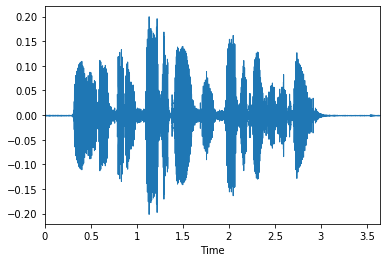

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00218.wav


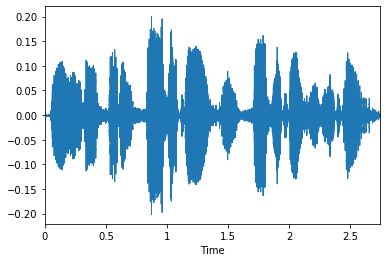

In [ ]:
silence_audio = RemoveSilence(threshold=20, pad_ms=20)(audio_orig)
audio_orig.show()
silence_audio.show()
#test that at least a half second of silence is being removed
test(silence_audio.nsamples + 8000, audio_orig.nsamples, operator.le)

In [ ]:
#test that nothing is removed from audio that doesnt contain silence
test_aud = AudioItem((torch.rand_like(audio_orig.sig), 16000, None))
print("Random Noise, no silence")
test_aud.hear()
for rm_type in [RemoveType.All, RemoveType.Trim, RemoveType.Split]:
    silence_audio_trim = RemoveSilence(rm_type, threshold=20, pad_ms=20)(test_aud)
    test_eq(test_aud.nsamples, silence_audio_trim.nsamples)

Random Noise, no silence


In [ ]:
# trim silence from a multichannel clip, needs more extensive testing
silence_mc = RemoveSilence(threshold=20, pad_ms=20)(fake_multichannel)
print(silence_mc.sig.shape) #still 3 channels
fake_multichannel.hear()
silence_mc.hear()

torch.Size([3, 40640])


#### Trim Silence Timing Tests

In [ ]:
silencer = RemoveSilence(threshold=20, pad_ms=20)

In [ ]:
%%timeit -n10
silencer(audio_orig)

1.9 ms ± 66 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit -n10
silencer(fake_multichannel)

1.56 ms ± 62.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Resampling

In [ ]:
#export
def Resample(sr_new):
    def _inner(ai:AudioItem)->AudioItem:
        '''Resample using faster polyphase technique and avoiding FFT computation'''
        if(ai.sr == sr_new): return AudioItem(ai)
        sig_np = ai.sig.numpy()
        sr_gcd = math.gcd(ai.sr, sr_new)
        resampled = resample_poly(sig_np, int(sr_new/sr_gcd), int(ai.sr/sr_gcd), axis=-1)
        resampled = resampled.astype(np.float32)
        return AudioItem((torch.from_numpy(resampled), sr_new, ai.path))
    return _inner

In [ ]:
#Make sure if old and new sample rates are the same, a new identical AudioItem is returned
no_resample_needed = Resample(audio_orig.sr)(audio_orig)
assert(not no_resample_needed is audio_orig)
test_eq(audio_orig.sr, no_resample_needed.sr)
test_eq(audio_orig.sig, no_resample_needed.sig)

In [ ]:
#test and hear realistic sample rates
print("Original, Sample Rate", audio_orig.sr)
audio_orig.hear()
for rate in [4000,8000,22050,44100]:
    resampled = Resample(rate)(audio_orig)
    orig_samples = audio_orig.nsamples
    re_samples = resampled.nsamples
    print("Sample Rate", rate)
    resampled.hear()
    test_eq(re_samples, orig_samples//(audio_orig.sr/rate))

Original, Sample Rate 16000


Sample Rate 4000


Sample Rate 8000


Sample Rate 22050


Sample Rate 44100


In [ ]:
#resample a multichannel audio
resampled = Resample(8000)(fake_multichannel)
test_eq(fake_multichannel.nsamples//2, resampled.nsamples)
test_eq(fake_multichannel.nchannels, resampled.nchannels)
test_eq(resampled.sr, 8000)

In [ ]:
for i in range(100):
    random_sr = random.randint(16000, 72000)
    random_upsample = Resample(random_sr)(audio_orig)
    num_samples = random_upsample.nsamples
    test_close(num_samples, abs(orig_samples//(audio_orig.sr/random_sr)), eps=1.1)

#### Resample Timing Tests

In [ ]:
# Polyphase resampling's speed is dependent on the GCD between old and new rate. For almost all used sample rates it
# will be very fast and much better than any FFT based method. It is slow however in the unlikely event that the 
# GCD is small (demonstrated below w GCD of 1 for last 2 examples)
common_downsample = Resample(8000)
slow_downsample = Resample(8001)
slow_upsample = Resample(27101)

In [ ]:
%%timeit -n10
common_downsample(audio_orig)

1.89 ms ± 64.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit -n10
common_downsample(fake_multichannel)

4.53 ms ± 88.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit -n10
slow_downsample(audio_orig)

42.7 ms ± 694 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit -n10
slow_upsample(audio_orig)

# Signal Transforms

## Signal Cropping/Padding

<div class = "alert alert-block alert-info"> CropSignal and CropTime can either be merged into one function, or they can outsource the bulk of their behavior to a shared cropping function</div>

In [ ]:
#export
mk_class('AudioPadType', **{o:o.lower() for o in ['Zeros', 'Zeros_After', 'Repeat']},
         doc="All methods of padding audio as attributes to get tab-completion and typo-proofing")

In [ ]:
#export
def CropSignal(duration, pad_mode=AudioPadType.Zeros):
    def _inner(ai: AudioItem)->AudioItem:
        '''Crops signal to be length specified in ms by duration, padding if needed'''
        sig = ai.sig.clone()
        orig_samples = ai.nsamples
        crop_samples = int((duration/1000)*ai.sr)
        if orig_samples < crop_samples: 
            sig_pad = _tfm_pad_signal(sig, crop_samples, pad_mode=pad_mode)
            return AudioItem((sig_pad, ai.sr, ai.path))
        elif orig_samples == crop_samples: return AudioItem((sig, ai.sr, ai.path))
        else:
            crop_start = random.randint(0, int(orig_samples-crop_samples))
            sig_crop = sig[:,crop_start:crop_start+crop_samples]
            return AudioItem((sig_crop, ai.sr, ai.path))
    return _inner

In [ ]:
#export
def _tfm_pad_signal(sig, width, pad_mode=AudioPadType.Zeros):
    '''Pad spectrogram to specified width, using specified pad mode'''
    c,x = sig.shape
    pad_m = pad_mode.lower()
    if pad_m in ["zeros", "zeros_after"]:
        zeros_front = random.randint(0, width-x) if pad_m == "zeros" else 0
        pad_front = torch.zeros((c, zeros_front))
        pad_back = torch.zeros((c, width-x-zeros_front))
        return torch.cat((pad_front, sig, pad_back), 1)
    elif pad_m == "repeat":
        repeats = width//x + 1
        return sig.repeat(1,repeats)[:,:width]
    else:
        raise ValueError(f"pad_mode {pad_m} not currently supported, only 'zeros', 'zeros_after', or 'repeat'")

In [ ]:
cropsig_1000ms = CropSignal(1000)
cropsig_2000ms = CropSignal(2000)
cropsig_5000ms = CropSignal(5000, pad_mode=AudioPadType.Zeros_After)
print(f"Audio is {audio_orig.duration} seconds")

In [ ]:
aud1s = cropsig_1000ms(audio_orig)
aud2s = cropsig_2000ms(audio_orig)
aud5s = cropsig_5000ms(audio_orig)

In [ ]:
audio_orig.show()
aud1s.show()
aud2s.show()
aud5s.show()

In [ ]:
test_eq(aud1s.nsamples, 1*audio_orig.sr)
test_eq(aud2s.nsamples, 2*audio_orig.sr)
test_eq(aud5s.nsamples, 5*audio_orig.sr)
test_eq(aud1s.duration, 1)
test_eq(aud2s.duration, 2)
test_eq(aud5s.duration, 5)

In [ ]:
mc1s = cropsig_1000ms(fake_multichannel)
mc2s = cropsig_2000ms(fake_multichannel)
mc5s = cropsig_5000ms(fake_multichannel)
test_eq(mc1s.duration, 1)
test_eq(mc2s.duration, 2)
test_eq(mc5s.duration, 5)

### Test Signal Padding Modes

In [ ]:
# test pad_mode zeros-after
test_aud = AudioItem((torch.rand_like(audio_orig.sig), 16000, None))
cropsig_pad = CropSignal(5000, pad_mode=AudioPadType.Zeros_After)
z_after = cropsig_pad(test_aud)
test_aud.hear()
z_after.hear()
# test end of signal is padded with zeros
test_eq(z_after.sig[:,-10:], torch.zeros_like(z_after.sig)[:,-10:])
# test front of signal is not padded with zeros
test_ne(z_after.sig[:,0:10] , z_after.sig[:,-10:])

In [ ]:
# test pad_mode zeros by verifying signal begins and ends with zeros
test_aud.hear()
cropsig_pad = CropSignal(5000)
z_after = cropsig_pad(test_aud)
z_after.hear()
test_eq(z_after.sig[:,0:2], z_after.sig[:,-2:])

In [ ]:
# test pad_mode repeat by making sure that columns are equal at the appropriate offsets
cropsig_repeat = CropSignal(12000, pad_mode=AudioPadType.Repeat)
ai_repeat = cropsig_repeat(audio_orig)
ai_repeat.show()
sig_repeat = ai_repeat.sig
for i in range(audio_orig.nsamples):
    test_eq(sig_repeat[:,i], sig_repeat[:,i+audio_orig.nsamples])
    test_eq(sig_repeat[:,i], sig_repeat[:,i+2*audio_orig.nsamples])

In [ ]:
# test bad pad_mode doesnt fail silently
test_fail(CropSignal(12000, pad_mode="tenchify"))

In [ ]:
# demonstrate repeat mode works on multichannel data (uncomment to see)
mc_repeat = cropsig_repeat(fake_multichannel)
#mc_repeat.show()

#### Cropping/Padding Timing Tests

In [ ]:
%%timeit -n10
aud1s = cropsig_1000ms(audio_orig)

In [ ]:
%%timeit -n10
aud2s = cropsig_2000ms(audio_orig)

In [ ]:
%%timeit -n10
aud5s = cropsig_5000ms(audio_orig)

## Signal Shifting

In [ ]:
#v1 used scipy.ndimage.interpolation.shift but it was extremely slow (14-16ms) so I rewrote and got it down to 50µs
def _shift(sig, s):
    channels, samples = sig.shape[-2:]
    if   s == 0: return torch.clone(sig)
    elif  s < 0: return torch.cat([sig[...,-1*s:], torch.zeros_like(sig)[...,s:]], dim=-1)
    else       : return torch.cat([torch.zeros_like(sig)[...,:s], sig[...,:samples-s]], dim=-1)

In [ ]:
t1 = torch.tensor([[1,2,3,4,5,6,7,8,9,10]])
t3 = torch.tensor([[1,2,3,4,5,6,7,8,9,10],[11,12,13,14,15,16,17,18,19,20],[21,22,23,24,25,26,27,28,29,30]])
b4 = torch.stack([t3,t3,t3,t3])
test_eq(b4.shape, torch.Size([4, 3, 10]))
test_eq(_shift(t1,4), tensor([[0, 0, 0, 0, 1, 2, 3, 4, 5, 6]]))
test_eq(_shift(t3,-2), tensor([[3,4,5,6,7,8,9,10,0,0],[13,14,15,16,17,18,19,20,0,0],[23,24,25,26,27,28,29,30,0,0]]))

In [ ]:
#export
def ShiftSignal(max_pct=0.2, max_time=None, roll=False):
    def _inner(ai: AudioItem)->AudioItem:
        s = int(random.uniform(-1, 1)*max_pct*ai.nsamples if max_time is None else random.uniform(-1, 1)*max_time*ai.sr)
        sig = torch.from_numpy(np.roll(ai.sig.numpy(), s, axis=1)) if roll else _shift(ai.sig, s) 
        return AudioItem((sig, ai.sr, ai.path))
    return _inner

### Example without rolling

In [ ]:
shifter = ShiftSignal(max_pct=0.3)
shifted = shifter(audio_orig)
audio_orig.show()
shifted.show()
test_eq(audio_orig.sig.shape, shifted.sig.shape)

In [ ]:
# test a time shift of 1s never shifts more than 1s
for i in range(100):
    time_shifter = ShiftSignal(max_time=1)
    just_ones = AudioItem((torch.ones(16000).unsqueeze(0), 16000, None))
    shifted = time_shifter(just_ones)
    test_eq(False, torch.allclose(shifted.sig, torch.zeros(16000)))

In [ ]:
# demonstrate shifting works on multichannel data (uncomment to see)
shifter = ShiftSignal(max_time=2)
mc_shifted = shifter(fake_multichannel)
#mc_shifted.show()

### Example with rolling

In [ ]:
shift_and_roll = ShiftSignal(0.4, roll=True)
shifted = shift_and_roll(audio_orig)
audio_orig.show()
shifted.show()
test_eq(audio_orig.sig.shape, shifted.sig.shape)

#### Shift Timing Tests

In [ ]:
%%timeit -n10
shifted = shifter(audio_orig)

In [ ]:
%%timeit -n10
shifted = shift_and_roll(audio_orig)

## Add Noise to Signal

Adds noise proportional to the energy of the signal (mean of abs value), and the specified noise level.

This uses [colorednoise](https://github.com/felixpatzelt/colorednoise)(imported as 'cn'), developed by a data scientist named [Felix Patzelt](https://github.com/felixpatzelt). It allows you to use one simple function to create white, brown, pink and other [colors of noise](https://en.wikipedia.org/wiki/Colors_of_noise). Each color corresponds to an exponent, violet is -2, blue -1, white is 0, pink is 1, and brown is 2. We abstract this with a class that enumerates the list and shifts it down by two so the exponents are correct, and so that we get tab-completion.

Because this actually draws a spectrogram and does an istft on it, it is about 10x faster if we implement our own white noise (simple and worth doing since it's the most common noise we'll want to use, this is what the `if color=0` line does, it overrides and generates white noise using our own simple algo.

For just plain white noise, if we revert to remove the dependency on this library, the noise can be created with  
`noise = torch.randn_like(ai.sig) * ai.sig.abs().mean() * noise_level`

In [ ]:
# export
mk_class('NoiseColor', **{o:i-2 for i,o in enumerate(['Violet', 'Blue', 'White', 'Pink', 'Brown'])},
         doc="All possible colors of noise as attributes to get tab-completion and typo-proofing")

In [ ]:
# export
def AddNoise(noise_level=0.05, color=NoiseColor.White):
    def _inner(ai: AudioItem)->AudioItem:
        # if it's white noise, implement our own for speed
        if color==0: noise = torch.randn_like(ai.sig)
        else:        noise = torch.from_numpy(cn.powerlaw_psd_gaussian(exponent=color, size=ai.nsamples)).float()
        scaled_noise = noise * ai.sig.abs().mean() * noise_level
        return AudioItem((ai.sig + scaled_noise, ai.sr, ai.path))
    return _inner

### White noise examples (default)

In [ ]:
noisy = AddNoise()(audio_orig)
real_noisy = AddNoise(noise_level=0.5)(audio_orig)
msgs = ["Original Audio", "5% White Noise", "50% White Noise"]
for i, aud in enumerate([audio_orig, noisy, real_noisy]):
    print(msgs[i])
    aud.show()

### Pink Noise Examples

In [ ]:
noisy = AddNoise(color=NoiseColor.Pink)(audio_orig)
real_noisy = AddNoise(noise_level=1, color=NoiseColor.Pink)(audio_orig)
msgs = ["Original Audio", "5% Pink Noise", "100% Pink Noise"]
for i, aud in enumerate([audio_orig, noisy, real_noisy]):
    print(msgs[i])
    aud.show()

In [ ]:
# demonstrate blue-noise on multichannel data (uncomment to see)
noisy = AddNoise(noise_level=0.5, color=NoiseColor.Blue)(fake_multichannel)
#noisy.show()

#### Noise Timing Tests

In [ ]:
%%timeit -n10
noise = torch.from_numpy(cn.powerlaw_psd_gaussian(exponent=0, size=audio_orig.nsamples)).float()
scaled_noise = noise * audio_orig.sig.abs().mean() * 0.05
out = AudioItem((audio_orig.sig + scaled_noise,audio_orig.sr, audio_orig.path))

In [ ]:
%%timeit -n10
#Same speed for white noise and brown noise using their algorithm
noise = torch.from_numpy(cn.powerlaw_psd_gaussian(exponent=2, size=audio_orig.nsamples)).float()
scaled_noise = noise * audio_orig.sig.abs().mean() * 0.05
out = AudioItem((audio_orig.sig + scaled_noise,audio_orig.sr, audio_orig.path))

In [ ]:
%%timeit -n10
noisy = AddNoise()(audio_orig)

## Adjust Volume

<div class = "alert alert-block alert-warning"><strong>Note:</strong><br> 
   This will increase/decrease the energy of the signal but so far it appears to do nothing besides change the absolute values as the audios sound the same, and the spectrograms appear the same. The gain is being correctly applied, but the ipython audio player seems to normalize the volume level (confirmed by outputting and downloading the clips and confirming a difference in noise level). The spectrogram appears the same because it too does a form of normalization when it sets `ref`. We will likely need to adjust the ref value to something constant like np.max or 0 to stop this normalization, as the noise_level is often relevant for deep learning and not something we want to strip out.<br></div>


In [ ]:
#export
def ChangeVolume(lower=0.1, upper=1.2):
    def _inner(ai: AudioItem)->AudioItem:
        gain = random.uniform(lower, upper)
        return AudioItem((gain*ai.sig, ai.sr, ai.path))
    return _inner

In [ ]:
#ipython player normalizes out volume difference, note different y-axis scale but same sound.
volume_adjuster = ChangeVolume(lower=0.1, upper=0.2)
altered = volume_adjuster(audio_orig)
audio_orig.show()
altered.show()

#### Adjust Volume Timing Tests

In [ ]:
%%timeit -n10
volume_adjuster(audio_orig)

In [ ]:
%%timeit -n10
volume_adjuster(fake_multichannel)

## Signal Cutout

In [ ]:
#export
def SignalCutout(cut_pct=0.15):
    def _inner(ai: AudioItem)->AudioItem:
        copy = ai.sig.clone()
        mask = torch.zeros(int(ai.nsamples*cut_pct))
        mask_start = random.randint(0,ai.nsamples-len(mask))
        copy[:,mask_start:mask_start+len(mask)] = mask
        return AudioItem((copy, ai.sr, ai.path))
    return _inner

In [ ]:
cutter = SignalCutout()
cut = cutter(audio_orig)

In [ ]:
cut.show()

In [ ]:
# demonstrate SignalCutout on multichannel, confirm the cuts align, uncomment to show
cut_mc = SignalCutout(cut_pct=0.2)(fake_multichannel)
#cut_mc.show()

#### Signal Cutout Timing Tests

In [ ]:
%%timeit -n10
cutter(audio_orig)

In [ ]:
%%timeit -n10
cutter(fake_multichannel)

## Signal Loss 

In [ ]:
#export
# Code adjusted from orig v1 fastai audio by Zack Caceres, Thom Mackey, and Stefano Giomo
def SignalDrop(cut_pct=0.15):
    def _inner(ai: AudioItem)->AudioItem:
        """Randomly replaces amplitude of signal with 0. Simulates analog info loss"""
        copy = ai.sig.clone()
        mask = (torch.rand_like(copy[0])>cut_pct).float()
        masked = copy * mask
        return AudioItem((masked, ai.sr, ai.path))
    return _inner

In [ ]:
dropper = SignalDrop()
dropped = dropper(audio_orig)
dropped.show()

In [ ]:
# verify SignalDrop is dropping both the correct number of samples, and dropping
# the same samples from each channel, over a wide range of cut_pcts
nsamples = fake_multichannel.nsamples
for cut_pct in np.linspace(0.05, 0.5, 45):
    dropped_mc = SignalDrop(cut_pct)(fake_multichannel)
    match1 = (dropped_mc.sig[0] == dropped_mc.sig[1]).sum()
    match2 = (dropped_mc.sig[0] == dropped_mc.sig[2]).sum()
    match3 = (dropped_mc.sig[1] == dropped_mc.sig[2]).sum()
    test_close(match1, cut_pct*nsamples, eps=.02*nsamples)
    test_close(match2, cut_pct*nsamples, eps=.02*nsamples)
    test_close(match3, cut_pct*nsamples, eps=.02*nsamples)

#### Signal Drop Timing Tests

In [ ]:
%%timeit -n10
dropper(audio_orig)

In [ ]:
%%timeit -n10
dropper(fake_multichannel)

## DownmixMono

In [ ]:
#export
# downmixMono was removed from torchaudio, we now just take the mean across channels
# this works for both batches and individual items

def DownmixMono():
    def _inner(ai: AudioItem)->AudioItem:
        """Randomly replaces amplitude of signal with 0. Simulates analog info loss"""
        downmixed = ai.sig.contiguous().mean(-2).unsqueeze(-2)
        return AudioItem((downmixed, ai.sr, ai.path))
    return _inner

In [ ]:
downmixed = DownmixMono()(fake_multichannel)
fake_multichannel.show()
downmixed.show()

In [ ]:
# test downmixing 1 channel has no effect
downmixer = DownmixMono()
downmixed = downmixer(audio_orig)
test_eq(downmixed.sig, audio_orig.sig)

In [ ]:
# example showing a batch of 4 signals 
f2 = fake_multichannel.sig.unsqueeze(0)
fake_batch = torch.cat([f2,f2,f2,f2], dim=0)
downmixed = fake_batch.contiguous().mean(-2).unsqueeze(-2)
print("Before shape:", fake_batch.shape)
print("After shape:", downmixed.shape)

#### DownmixMono Timing Tests

In [ ]:
%%timeit -n10
downmixer(fake_multichannel)

# Spectrogram Transforms

##  Time Cropping

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong><br> 
   1. In spectrogram when we pad with mean value we mess up normalization by altering std dev, how can we use fill values that dont mess things up<br></div>


In [ ]:
#export
def CropTime(duration, pad_mode=AudioPadType.Zeros):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Random crops full spectrogram to be length specified in ms by crop_duration'''
        sg = spectro.clone()
        sr, hop = spectro.sr, spectro.hop_length
        w_crop = int((sr*duration)/(1000*hop))+1
        w_sg   = sg.shape[-1]
        if   w_sg <  w_crop: 
            sg_pad = _tfm_pad_spectro(sg, w_crop, pad_mode=pad_mode)
            return AudioSpectrogram.create(sg_pad, settings=spectro.settings)
        elif w_sg == w_crop: return sg
        else:
            crop_start = random.randint(0, int(w_sg - w_crop))
            sg_crop = sg[:,:,crop_start:crop_start+w_crop]
            sg_crop.sample_start = int(crop_start*hop)
            sg_crop.sample_end   = sg_crop.sample_start + int(duration*sr)
            return AudioSpectrogram.create(sg_crop, settings=spectro.settings)
    return _inner

In [ ]:
#export
def _tfm_pad_spectro(sg, width, pad_mode=AudioPadType.Zeros):
    '''Pad spectrogram to specified width, using specified pad mode'''
    c,y,x = sg.shape
    pad_m = pad_mode.lower()
    if pad_m in ["zeros", "zeros_after"]:
        zeros_front = random.randint(0, width-x) if pad_m == "zeros" else 0
        pad_front = torch.zeros((c,y, zeros_front))
        pad_back = torch.zeros((c,y, width-x-zeros_front))
        return AudioSpectrogram(torch.cat((pad_front, sg, pad_back), 2))
    elif pad_m == "repeat":
        repeats = width//x + 1
        return sg.repeat(1,1,repeats)[:,:,:width]
    else:
        raise ValueError(f"pad_mode {pad_m} not currently supported, only 'zeros', 'zeros_after', or 'repeat'")

In [ ]:
crop_1000ms = CropTime(1000)
crop_2000ms = CropTime(2000)
crop_5000ms = CropTime(5000)
print(f"Audio is {audio_orig.duration} seconds")

In [ ]:
s1 = crop_1000ms(sg_orig)
s1.show()
s2 = crop_2000ms(sg_orig)
s2.show()
s5 = crop_5000ms(sg_orig)
s5.show()

<div class = "alert alert-block alert-info"><strong>Note:</strong><br> 
    Because a spectrograms duration is dependent on rounding (samples/hop_length usually has a remainder that is padded up to an extra pixel), we cant use exact durations, so we must test_close instead of test_eq. This could be fixed by storing the AudioItems duration when the sg is generated, and also updating the duration manually anytime a Transform occurs that affects the size time axis (x-axis)
</div>


In [ ]:
test_eq(sg_orig.settings, s1.settings)
test_eq(sg_orig.settings, s5.settings)
test_close(s1.width, int((1/sg_orig.duration)*sg_orig.width), eps=1.01)
test_close(s2.width, int((2/sg_orig.duration)*sg_orig.width), eps=1.01)
test_close(s5.width, int((5/sg_orig.duration)*sg_orig.width), eps=1.01)

In [ ]:
# test AudioToSpec->CropTime and CropSignal->AudioToSpec will result in same size images
oa = OpenAudio(files)
crop_dur = random.randint(1000,5000)
pipe_cropsig  = Pipeline([oa, AudioToSpec(hop_length=128), CropTime(crop_dur)], as_item=True)
pipe_cropspec = Pipeline([oa, CropSignal(crop_dur), AudioToSpec(hop_length=128), ], as_item=True)
for i in range(50):
    test_eq(pipe_cropsig(i).width, pipe_cropspec(i).width)

In [ ]:
# test pad_mode zeros-after by verifying sg ends with zeros and begins with non-zeros
crop_5000ms = CropTime(5000, pad_mode=AudioPadType.Zeros_After)
s5 = crop_5000ms(sg_orig)
test_eq(s5[:,:,-1], torch.zeros_like(s5)[:,:,-1])
test_ne(s5[:,:,0], torch.zeros_like(s5)[:,:,-1])

In [ ]:
sg_orig.duration

In [ ]:
# test pad_mode repeat by making sure that columns are equal at the appropriate offsets
crop_12000ms_repeat = CropTime(12000, pad_mode=AudioPadType.Repeat)
s12_repeat = crop_12000ms_repeat(sg_orig)
s12_repeat.show()
for i in range(sg_orig.width):
    test_eq(s12_repeat[:,:,i], s12_repeat[:,:,i+sg_orig.width])
    test_eq(s12_repeat[:,:,i], s12_repeat[:,:,i+2*sg_orig.width])

In [ ]:
# test bad pad_mode doesnt fail silently, correct is 'zeros_after'
test_fail(CropTime(12000, pad_mode="zerosafter"))

In [ ]:
s1.shape, s2.shape, s5.shape

In [ ]:
# demonstrate on multichannel audio, uncomment to show
sg_multi = a2s(fake_multichannel)
s1_mc = crop_1000ms(sg_multi)
#s1_mc.show()

#### CropTime Timing Tests

In [ ]:
%%timeit -n10
#1s zero-padded crop
crop_1000ms(sg_orig)

In [ ]:
%%timeit -n10
#5s zero-padded crop
crop_5000ms(sg_orig)

In [ ]:
%%timeit -n10
#12s repeat-padded crop
crop_12000ms_repeat(sg_orig)

<div class = "alert alert-block alert-info"> If we wanted to we could make a class for these transforms that keeps the masked portion as state so that we could write a decodes method to go back to the original</div>


## Time and Frequency Masking (SpecAugment)

In [ ]:
#export
def MaskFreq(num_masks=1, size=20, start=None, val=None, **kwargs):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Google SpecAugment time masking from https://arxiv.org/abs/1904.08779.'''
        nonlocal start
        sg = spectro.clone()
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:,None,None]
        mask_val = channel_mean if val is None else val
        c, y, x = sg.shape
        for _ in range(num_masks):
            mask = torch.ones(size, x) * mask_val    
            if start is None: start= random.randint(0, y-size)
            if not 0 <= start <= y-size:
                raise ValueError(f"Start value '{start}' out of range for AudioSpectrogram of shape {sg.shape}")
            sg[:,start:start+size,:] = mask
            start = None
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

<div class = "alert alert-block alert-warning"> Passing around the settings manually is already fairly clunky, but is especially bad when we have to do it twice when MaskTime hands off to MaskFrequency. We should maybe make a copy of the AudioSpectrogram and then alter the tensor for it's sg rather than cloning out the sg and then building a new object at the end. Or just keep a reference to the parent tensor and pass that along, and have getattr recur looking for settings of the parents</div>


In [ ]:
#export
def MaskTime(num_masks=1, size=20, start=None, val=None, **kwargs):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        sg = spectro.clone()
        sg = torch.einsum('...ij->...ji', sg)
        sg = AudioSpectrogram.create(sg, settings=spectro.settings)
        sg = MaskFreq(num_masks, size, start, val, **kwargs)(sg)
        return AudioSpectrogram.create(torch.einsum('...ij->...ji', sg), settings=spectro.settings)
    return _inner

In [ ]:
freq_mask = MaskFreq()

In [ ]:
%%time
freq_mask(sg_orig).show()

In [ ]:
%%time
time_mask = MaskTime()
time_mask(sg_orig).show()

In [ ]:
# create a random frequency mask and test that it is being correctly applied
size, start, val = [random.randint(1, 50) for i in range(3)]
freq_mask_test = MaskFreq(size=size, start=start, val=val)
sg_test = freq_mask_test(sg_orig)
sg_test.show()
test_eq(sg_test[:,start:start+size,:], val*torch.ones_like(sg_orig)[:,start:start+size,:])

In [ ]:
# create a random time mask and test that it is being correctly applied
size, start, val = [random.randint(1, 50) for i in range(3)]
time_mask_test = MaskTime(size=size, start=start, val=val)
sg_test = time_mask_test(sg_orig)
sg_test.show()
test_eq(sg_test[:,:,start:start+size], val*torch.ones_like(sg_orig)[:,:,start:start+size])

In [ ]:
# demonstrate on multichannel audio, uncomment to show, note bar is black so can be hard to see
sg_multi = a2s(fake_multichannel)
masked_mc = MaskFreq(size=40)(sg_multi)
#masked_mc.show()

#### SpecAugment Timing Tests

In [ ]:
%%timeit -n10
freq_mask(sg_orig)

In [ ]:
%%timeit -n10
# time masking ~80µs slower because we transpose, delegate to MaskFreq, and transpose back, we could
# fix this at the expense of a bit more code 
time_mask(sg_orig)

In [ ]:
%%timeit -n10
freq_mask(sg_multi)

## Spectrogram Rolling

In [ ]:
#export
def SGRoll(max_shift_pct=0.5, direction=0, **kwargs):
    '''Shifts spectrogram along x-axis wrapping around to other side'''
    if int(direction) not in [-1, 0, 1]: 
        raise ValueError("Direction must be -1(left) 0(bidirectional) or 1(right)")
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        nonlocal direction
        direction = random.choice([-1, 1]) if direction == 0 else direction
        sg = spectro.clone()
        w = sg.shape[-1]
        roll_by = int(w*random.random()*max_shift_pct*direction)
        sg = sg.roll(roll_by, dims=-1)
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
roller = SGRoll()

In [ ]:
sg_orig.show()

In [ ]:
roller(sg_orig).show()

In [ ]:
roller(sg_orig).show()

In [ ]:
#fails occasionally when by chance roll is 0, but i dont want to change to >= or <= because 
#it wont detect a broken roll! Could maybe scrap this test, it's overly complex
def _first_non_zero_col(t):
    for i in range(t.shape[2]):
        if(t[0,0,i].item() == 1): return i
roll_spec = a2s(audio_orig)
mid = int((roll_spec.width/2))-5
test_spec = torch.zeros_like(roll_spec)
test_spec[:,:,mid:mid+10] = 1
roll_spec.data = test_spec
left_roller = SGRoll(max_shift_pct=0.4, direction=-1)
left_spec = left_roller(roll_spec).data
right_roller = SGRoll(max_shift_pct=0.4, direction=1)
right_spec = right_roller(roll_spec).data
ostart, lstart, rstart = map(_first_non_zero_col, (test_spec, left_spec, right_spec))
test(lstart, ostart, operator.lt)
test(rstart, ostart, operator.gt)

In [ ]:
# demonstrate rolling on multichannel audio, uncomment to show
sg_multi = a2s(fake_multichannel)
rolled_mc = roller(sg_multi)
#rolled_mc.show()

#### SGRollTiming Tests

In [ ]:
%%timeit -n10
roller(sg_orig)

In [ ]:
%%timeit -n10
roller(sg_multi)

## Delta/Accelerate 

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong> Test delta as part of a pipeline to make sure SpecAugment/roll/interpolate...etc are working on multichannel</div>


In [ ]:
#export
def _torchdelta(mel:AudioSpectrogram, order=1, width=9):
    '''Converts to numpy, takes delta and converts back to torch, needs torchification'''
    if(mel.shape[1] < width): 
        raise ValueError(f'''Delta not possible with current settings, inputs must be wider than 
        {width} columns, try setting max_to_pad to a larger value to ensure a minimum width''')
    return AudioSpectrogram(torch.from_numpy(librosa.feature.delta(mel.numpy(), order=order, width=width)))

In [ ]:
#export
def Delta(width=9):
    td = partial(_torchdelta, width=width)
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        new_channels = [torch.stack([c, td(c, order=1), td(c, order=2)]) for c in spectro]
        return AudioSpectrogram.create(torch.cat(new_channels), settings=spectro.settings)
    return _inner

In [ ]:
delta = Delta()

In [ ]:
d = delta(sg_orig)
print("Shape",d.shape)
d.show()
#nchannels for a spectrogram is how many channels its original audio had
test_eq(d.nchannels, audio_orig.nchannels)
test_eq(d.shape[1:], sg_orig.shape[1:])
test_ne(d[0],d[1])

In [ ]:
# demonstrate delta on multichannel audio, wont work until sg display is fixed
sg_multi = a2s(fake_multichannel)
delta_mc = delta(sg_multi)
delta_mc.show()

#### Delta Timing Tests

In [ ]:
%%timeit -n10
delta(sg_orig)

In [ ]:
%%timeit -n10
delta(sg_multi)

## Image resizing

<div class = "alert alert-block alert-info"> This should probably be refactored to use visions size transform since it already exists</div>


In [ ]:
#export
def TfmResize(size, interp_mode="bilinear", **kwargs):
    '''Temporary fix to allow image resizing transform'''
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        nonlocal size
        if isinstance(size, int): size = (size, size)
        sg = spectro.clone()
        c,y,x = sg.shape
        sg = F.interpolate(sg.unsqueeze(0), size=size, mode=interp_mode, align_corners=False).squeeze(0)
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
# Test when size is an int
size=224
resizer = TfmResize(size)
resized = resizer(sg_orig)
print("Original Shape: ", sg_orig.shape)
print("Resized Shape :" , resized.shape)
test_eq(resized.shape[1:], torch.Size([size,size]))

In [ ]:
# Test when size is a tuple with unequal values
size_tup=(124,581)
resizer_tup = TfmResize(size_tup)
resized_tup = resizer_tup(sg_orig)
print("Original Shape: ", sg_orig.shape)
print("Resized Shape :" , resized_tup.shape)
resized_tup.show()
test_eq(resized_tup.shape[1:], torch.Size(size_tup))

In [ ]:
# demonstrate resizing on multichannel audio, uncomment to show
sg_multi = a2s(fake_multichannel)
resized_mc = TfmResize((200,100))(sg_multi)
#resized_mc.show()

#### Resize Timing Tests

In [ ]:
%%timeit -n10
resizer(sg_orig)

In [ ]:
%%timeit -n10
resizer(sg_multi)

# Pipelines

## Signal Pipelines

In [ ]:
files

In [ ]:
oa = OpenAudio(files); oa

## Signal Pipelines

In [ ]:
#Show simple preprocessing
preprocess_pipe = Pipeline([oa, RemoveSilence(), CropSignal(2000), Resample(8000)], as_item=True)
for i in range(3): preprocess_pipe(i).show()

In [ ]:
#Show a very noisy set of signal augmentations
augment_pipe1 = Pipeline([oa, RemoveSilence(), CropSignal(2000), AddNoise(noise_level=0.3), SignalDrop()], as_item=True)
for i in range(3): augment_pipe1(i).show()

In [ ]:
#Show another set of signal augmentations
augment_pipe2 = Pipeline([oa, RemoveSilence(), CropSignal(2000), AddNoise(color=NoiseColor.Blue), 
                          ShiftSignal(roll=True), SignalCutout()], as_item=True)
for i in range(3): augment_pipe2(i).show()

## Spectrogram Pipelines

In [ ]:
#Basic melspectrogram pipe with advanced SpecAugment 
sg_cfg = AudioConfig.BasicMelSpectrogram(hop_length=256, n_fft=2048)
pipe = Pipeline([oa, AudioToSpec.from_cfg(sg_cfg), CropTime(2000), MaskTime(num_masks=2, size=4), MaskFreq()], as_item=True)
for i in range(5): pipe.show(pipe(i))

In [ ]:
#Pipe with only spectrogram transforms, notably Delta/Accelerate appended
voice_cfg = AudioConfig.Voice()
delta_pipe = Pipeline([oa, AudioToSpec.from_cfg(voice_cfg), CropTime(2000), Delta(), MaskTime(size=4), MaskFreq(), ], as_item=True)
for i in range(5): delta_pipe.show(delta_pipe(i))

In [ ]:
for i in range(5): pipe.show(pipe(i))

In [ ]:
#Pipe with signal and spectro transforms, and a lot of noise
voice_cfg = AudioConfig.Voice()
everything_pipe = Pipeline([oa, 
                            RemoveSilence(), CropSignal(2000), AddNoise(noise_level=0.3), SignalDrop(), 
                            AudioToSpec.from_cfg(voice_cfg), MaskTime(size=4), MaskFreq(), Delta()], as_item=True)
for i in range(5): everything_pipe.show(everything_pipe(i))

# Export

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)